In [100]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import statistics as stats
import pandas as pd
import numpy as np
import re

# PREMISE

I'm sure we all know someone whose go to excuse is "[insert team here] vs Refs", or a sarcastic "I wonder who Vegas has in this one", when their favorite team loses a game. I know its hard to accept when your team has been flat out beat, but with Data Science we can actually analyze and see if refs tend to favorite the Vegas-favorited team, and if refs really do impact games in significant way, and many other questions you may have. 

This tutorial will describe and show examples of every step of the Data Science pipeline. 
1. Data Collection
2. Data Processing
3. Exploratory Analysis and Data Visualization
4. Analysis and Hypothesis Testing
5. Insight and Policy Decision

What we are going to do in this tutorial to start, is scrape data on NFL games - which referee reffed it, the moneyline and other betting lines, the play-by-play, who was home and who was away, etc. 

Once we get all the data we need in a tidy manner, and analyze it, we will be able to answer a lot of questions about refs tendencies, and just the overall patterns we can find regarding penalties, and you will be able to tell that friend either to just accept the loss, or that he has a legitimate claim. 

I will be displaying my work as often as I can, so that no one step is hard to follow (given the comments, as well).

Some good questions to look at are
1. When the favorited team goes behind, do the refs call more penalties on the opposing team
2. Do certain refs tend to favor certain calls, or certain teams
3. ...

## DATA COLLECTION

The first step in the Data Science pipeline is Data Collection, i.e. actually getting the data from some source into a data structure you can work with. What we want to do here is first collect all the data we need, via webscraping with BeautifulSoup and Requests, and then storing all the data in a Pandas dataframe.

Here, I have already downloaded an excel sheet from https://www.sportsbookreviewsonline.com/scoresoddsarchives/nfl/nfloddsarchives.html

We read it into an excel-sheet like data type called a Dataframe, from the Pandas module. (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

In [101]:
gamedata = pd.read_excel('nflodds.xlsx')
gamedata

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
0,909,451,V,Dallas,7,9,10,3,29,52.5,52.5,375,27
1,909,452,H,TampaBay,7,14,7,3,31,7,10,-450,2
2,912,453,V,Pittsburgh,0,0,6,17,23,51,47.5,240,0.5
3,912,454,H,Buffalo,3,7,0,6,16,7,7,-280,21.5
4,912,455,V,NYJets,0,0,8,6,14,43.5,44.5,160,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,130,322,H,KansasCity,7,14,0,3,24,7,7,-310,3
566,130,323,V,SanFrancisco,0,10,7,0,17,47.5,45.5,170,23.5
567,130,324,H,LARams,0,7,0,13,20,3,-3.5,-180,0.5
568,213,101,N,LARams,7,6,3,7,23,4,4,-200,0.5


This data contains information on games, and the moneyline, opening, halftime, and closing lines for a game.

What we now want to do now is scrape data for the play-by-play so we can see exactly when every single flag was thrown. The website we are scraping from, https://www.nflpenalties.com/all-referees.php?year=2021, contains links to each referees individual page. To analyze webpages, you don't need to know anything about HTML except how to  press right-click inspect and look through the HTML for what you want, and then utilize BeautifulSoup (https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and Regular Expressions to extract the information you want. BeautifulSoup parses the content returned by a request sent through the requests module, and turns it into something that you can use to search for specific elements of HTML.

In [102]:
URL = 'https://www.nflpenalties.com/all-referees.php?year=2021'
PREFIX = 'https://www.nflpenalties.com'

ref_to_games = {}

# get all links to the referees
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
elts = soup.find_all(href=True)

# compile regex for use in loop
match_referee = re.compile(r'<a href="(/referee/.*)">(.*)<')

for elt in elts: 
    # if the link is a link to a referee, add it to the mapping
    if ref := re.match(match_referee, str(elt)): # love the := operator 
        ref_to_games[ref.group(2)] = PREFIX+ref.group(1)
        
ref_to_games['Adrian Hill']

'https://www.nflpenalties.com/referee/adrian-hill?year=2021'

Throughout this tutorial, I will be using Adrian Hill as my example instead of printing every single ref.

Utilizing BeautifulSoup, the re module, and requests, we create a python dictionary, ref_to_games, that maps a referee to their webpage's link, as shown above.

From there, we then have to search through each link and see where that takes us. Looking at the HTML for the pages, I noticed that there is a link to every single game refereed by that ref. From there, we now the next step is to extract those links for each referee.

In [103]:
# compile regex for use in loop
match_game = re.compile(r'<a href="(/game/.*)">')

for ref, link in ref_to_games.items():
    games = []

    # get all links to the games for each referee
    page = requests.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')
    elts = soup.find_all(href=True)

    for elt in elts: 
        # if the link is a link to a game, add it to the list for that ref
        if game := re.match(match_game, str(elt)):
            games.append(PREFIX+game.group(1))
            
    ref_to_games[ref] = games
    
ref_to_games['Adrian Hill']

['https://www.nflpenalties.com/game/minnesota-vikings-at-cincinnati-bengals-09-12-2021',
 'https://www.nflpenalties.com/game/detroit-lions-at-green-bay-packers-09-20-2021',
 'https://www.nflpenalties.com/game/atlanta-falcons-at-new-york-giants-09-26-2021',
 'https://www.nflpenalties.com/game/tennessee-titans-at-new-york-jets-10-03-2021',
 'https://www.nflpenalties.com/game/kansas-city-chiefs-at-washington-football-team-10-17-2021',
 'https://www.nflpenalties.com/game/denver-broncos-at-cleveland-browns-10-21-2021',
 'https://www.nflpenalties.com/game/jacksonville-jaguars-at-seattle-seahawks-10-31-2021',
 'https://www.nflpenalties.com/game/houston-texans-at-miami-dolphins-11-07-2021',
 'https://www.nflpenalties.com/game/carolina-panthers-at-arizona-cardinals-11-14-2021',
 'https://www.nflpenalties.com/game/chicago-bears-at-detroit-lions-11-25-2021',
 'https://www.nflpenalties.com/game/washington-football-team-at-las-vegas-raiders-12-05-2021',
 'https://www.nflpenalties.com/game/seattle-s

In this code, we have updated the ref_to_games dictionary to map each referee to all links to the play-by-plays for the games that they refereed, as shown above.

Now, we have to go to through those links, and extract the play-by-play for each game.

In [104]:
pat = re.compile(r'game/(.*)-(\d\d-\d\d)-\d\d\d\d')

for ref, links in ref_to_games.items():
    games = []
    for i, link in enumerate(links):
        match = re.search(pat, link)
        date = match.group(2)
        matchup = match.group(1)
        games.append(pd.read_html(link, attrs={'class':'standard'})[0])
        games[i].insert(0, 'Date', [date for _ in range(0, games[i].shape[0])])
        games[i].insert(0, 'Matchup', [matchup for _ in range(0, games[i].shape[0])])
    ref_to_games[ref] = games
    
ref_to_games['Adrian Hill'][0]

,Matchup,Date,MIN,CIN,Poss,Time,Down,Distance,Yardline,Play
0,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,CIN,Q1 15:00,0,0,CIN 35,2-E.McPherson kicks 65 yards from CIN 35 to en...
1,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q1 15:00,1,10,MIN 25,"(15:00) PENALTY on MIN-30-C.Ham, False Start, ..."
2,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q1 15:00,1,15,MIN 20,(15:00) 8-K.Cousins pass short right to 33-D.C...
3,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q1 14:25,2,6,MIN 29,"(14:25) PENALTY on MIN-83-T.Conklin, False Sta..."
4,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q1 14:10,2,11,MIN 24,(14:10) 8-K.Cousins pass short middle to 83-T....
...,...,...,...,...,...,...,...,...,...,...
235,minnesota-vikings-at-cincinnati-bengals,09-12,24,24,CIN,Q5 00:06,2,5,MIN 15,(:06) 9-J.Burrow spiked the ball to stop the c...
236,minnesota-vikings-at-cincinnati-bengals,09-12,24,24,NaN,Q5 00:05,0,0,NaN,Timeout #1 by MIN at 00:05.
237,minnesota-vikings-at-cincinnati-bengals,09-12,24,27,CIN,Q5 00:05,3,5,MIN 15,(:05) 2-E.McPherson 38 yard field goal is GOOD...
238,minnesota-vikings-at-cincinnati-bengals,09-12,MIN,CIN,Poss,Time,Down,Distance,Yardline,Play


These few lines of code take a while to run, upwards of 2 minutes on my laptop to iterate through every NFL game played in a season, but after they run we have successfully updated ref_to_games dictionary to map referees to a list of Dataframes of play-by-play information for each game the referee coached. At this point we have finished scraping our data, and we have successfully stored the play-by-play for every single game in the season.

We also do a little bit of tidying up in preperation for below, we add the date of each game to every play of every game, which will come in handy below. We also extract the information for the names of the teams.

Printed above is the first game refereed by Adrian Hill in the 2021 season, ```ref_to_games[name][i]``` corresponds to the ```(i+1)th game``` coached by ```name```

## DATA PROCESSING

The second step 

We need to create an identifying variable for each matchup. This way, we will be able to easily compare between the two dataframes we have.


We also need to change the date to match the date format for the play-by-play data, and change the team names to their abreviated version for easy comparison with the play-by-play table, which we will do the same to.

In [105]:
date_pat = re.compile(r'(\d\d?)(\d\d)')

def parse_date(d):
    match = re.match(date_pat, str(d))
    month = '0'+match.group(1) if len(match.group(1)) == 1 else match.group(1)
    day = match.group(2)
    return f'{month}-{day}'

to_abv = {
    'Minnesota': 'MIN', 'GreenBay': 'GB', 'Chicago': 'CHI', 'Detroit': 'DET',
    'Cincinnati': 'CIN', 'Pittsburgh': 'PIT', 'Baltimore': 'BAL', 'Cleveland': 'CLE',
    'Dallas': 'DAL', 'Philadelphia': 'PHI', 'Washington': 'WAS', 'NYGiants': 'NYG',
    'NewEngland': 'NE', 'Buffalo': 'BUF', 'Miami': 'MIA', 'NYJets': 'NYJ',
    'TampaBay': 'TB', 'Atlanta': 'ATL', 'Carolina': 'CAR', 'NewOrleans': 'NO',
    'Jacksonville': 'JAX', 'Indianapolis': 'IND', 'Tennessee': 'TEN', 'Houston': 'HOU',
    'LARams': 'LAR', 'SanFrancisco': 'SF', 'Arizona': 'ARI', 'Seattle': 'SEA',
    'LasVegas': 'LV', 'LAChargers': 'LAC', 'KansasCity': 'KC', 'Denver': 'DEN'
}    

ids = gamedata.index
ids = [(count-1) if count%2==1 else count for count in ids]
del gamedata['Rot']
gamedata['ID'] = ids

dates = [parse_date(d) for d in gamedata['Date']]
del gamedata['Date']
gamedata['Date'] = dates

teams = [to_abv[team] for team in gamedata['Team']]
del gamedata['Team']
gamedata['Team'] = teams

gamedata = gamedata.drop(columns=['1st', '2nd', '3rd', '4th', 'Open', 'Close', '2H'])
gamedata

,VH,Final,ML,ID,Date,Team
0,V,29,375,0,09-09,DAL
1,H,31,-450,0,09-09,TB
2,V,23,240,2,09-12,PIT
3,H,16,-280,2,09-12,BUF
4,V,14,160,4,09-12,NYJ
...,...,...,...,...,...,...
565,H,24,-310,564,01-30,KC
566,V,17,170,566,01-30,SF
567,H,20,-180,566,01-30,LAR
568,N,23,-200,568,02-13,LAR


While iterating through the play-by-plays, I found that one of the dataframes is incorrectly formatted.

In [106]:
ref_to_games['John Hussey'][3]

,Matchup,Date,0,1,2,3,4,5,6,7
0,las-vegas-raiders-at-los-angeles-chargers,10-04,0,0,NaN,Q1,0,0,NaN,The game has been suspended. Kickoff has been ...
1,las-vegas-raiders-at-los-angeles-chargers,10-04,0,0,NaN,Q1,0,0,NaN,The game has resumed.
2,las-vegas-raiders-at-los-angeles-chargers,10-04,LV,LAC,Poss,Time,Down,Distance,Yardline,Play
3,las-vegas-raiders-at-los-angeles-chargers,10-04,0,0,LV,Q1 15:00,0,0,LV 35,2-D.Carlson kicks 65 yards from LV 35 to end z...
4,las-vegas-raiders-at-los-angeles-chargers,10-04,0,0,LAC,Q1 15:00,1,10,LAC 25,(15:00) (Shotgun) 10-J.Herbert pass short left...
...,...,...,...,...,...,...,...,...,...,...
200,las-vegas-raiders-at-los-angeles-chargers,10-04,14,28,LV,Q4 01:15,4,7,LV 13,(1:15) (Shotgun) 4-D.Carr pass incomplete shor...
201,las-vegas-raiders-at-los-angeles-chargers,10-04,LV,LAC,Poss,Time,Down,Distance,Yardline,Play
202,las-vegas-raiders-at-los-angeles-chargers,10-04,14,28,LAC,Q4 01:11,1,10,LV 13,(1:11) 10-J.Herbert kneels to LV 14 for -1 yards.
203,las-vegas-raiders-at-los-angeles-chargers,10-04,14,28,LAC,Q4 00:31,2,11,LV 14,(:31) 10-J.Herbert kneels to LV 15 for -1 yards.


As you can see, the labels for the dataframe are incorrectly formatted. We must tidy up this dataframe so that our iteration below will work.

In [107]:
ref_to_games['John Hussey'][3].columns = ref_to_games['Adrian Hill'][0].columns # adrian hills dataframe is correctly formatted

With this sorted, we can begin the rest of the tidying. 

We are only interested in penalties - not 5 yard incomplete checkdowns. So, we have to drop all rows in each game that does not detail a penalty

In [108]:
# compile regex for use in loop
penalty_pat = re.compile(r'PENALTY')

for ref, games in ref_to_games.items():
    for i, game in enumerate(games):
        
        # remove plays that dont contain penalty information
        filter = game['Play'].str.contains(penalty_pat)
        ref_to_games[ref][i] = game[filter]
    
ref_to_games['Adrian Hill'][0]

,Matchup,Date,MIN,CIN,Poss,Time,Down,Distance,Yardline,Play
1,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q1 15:00,1,10,MIN 25,"(15:00) PENALTY on MIN-30-C.Ham, False Start, ..."
3,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q1 14:25,2,6,MIN 29,"(14:25) PENALTY on MIN-83-T.Conklin, False Sta..."
7,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q1 12:30,2,9,MIN 43,"(12:30) PENALTY on MIN-30-C.Ham, False Start, ..."
8,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q1 12:16,2,14,MIN 38,(12:16) 8-K.Cousins pass short middle to 19-A....
55,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q2 09:33,2,13,CIN 25,"(9:33) PENALTY on MIN-17-K.Osborn, False Start..."
56,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q2 09:08,2,18,CIN 30,(9:08) (Shotgun) 8-K.Cousins pass incomplete s...
61,minnesota-vikings-at-cincinnati-bengals,09-12,0,0,MIN,Q2 07:08,2,9,CIN 10,(7:08) 8-K.Cousins sacked at CIN 20 for -10 ya...
73,minnesota-vikings-at-cincinnati-bengals,09-12,7,0,CIN,Q2 02:02,1,10,MIN 29,(2:02) (Shotgun) 9-J.Burrow pass incomplete de...
81,minnesota-vikings-at-cincinnati-bengals,09-12,7,7,MIN,Q2 01:44,2,10,MIN 25,(1:44) (Shotgun) 8-K.Cousins pass short middle...
94,minnesota-vikings-at-cincinnati-bengals,09-12,7,14,MIN,Q2 00:35,1,10,MIN 25,"(:35) (Shotgun) PENALTY on MIN-75-B.O'Neill, F..."


Now that we have only the plays that are penalties, we can do some tidying up, regarding the data in the columns.

In [109]:
# compile regex for use in loop
penalty_on_pat = re.compile(r'PENALTY on (\w+)(-|,)')
penalty_pat = re.compile(r',(.*), \d+ yard')
time_pat = re.compile(r'Q(\d)(.*)')
matchup_pat = re.compile(r'(.*)-at-(.*)')

to_abv = {
    'minnesota-vikings': 'MIN', 'green-bay-packers': 'GB', 'chicago-bears': 'CHI', 'detroit-lions': 'DET',
    'cincinnati-bengals': 'CIN', 'pittsburgh-steelers': 'PIT', 'baltimore-ravens': 'BAL', 'cleveland-browns': 'CLE',
    'dallas-cowboys': 'DAL', 'philadelphia-eagles': 'PHI', 'washington-football-team': 'WAS', 'new-york-giants': 'NYG',
    'new-england-patriots': 'NE', 'buffalo-bills': 'BUF', 'miami-dolphins': 'MIA', 'new-york-jets': 'NYJ',
    'tampa-bay-buccaneers': 'TB', 'atlanta-falcons': 'ATL', 'carolina-panthers': 'CAR', 'new-orleans-saints': 'NO',
    'jacksonville-jaguars': 'JAX', 'indianapolis-colts': 'IND', 'tennessee-titans': 'TEN', 'houston-texans': 'HOU',
    'los-angeles-rams': 'LAR', 'san-francisco-49ers': 'SF', 'arizona-cardinals': 'ARI', 'seattle-seahawks': 'SEA',
    'las-vegas-raiders': 'LV', 'los-angeles-chargers': 'LAC', 'kansas-city-chiefs': 'KC', 'denver-broncos': 'DEN'
}

# create a closure with the regex and the dictionary and this function
def matchup_parser(matchup):
    match = re.match(matchup_pat, matchup)
    away = to_abv[match.group(1)]
    home = to_abv[match.group(2)]
    return home, away

# closure
def penalty_parser(penalty):
    pen_on = re.search(penalty_on_pat, penalty).group(1)
    pen = re.search(penalty_pat, penalty).group(1)
    pen = (pen.split(','))[-1]
    return pen_on, pen

# closure
def time_parser(time):
    time_match = re.match(time_pat, time)
    quarter = time_match.group(1)
    time = time_match.group(2)
    return quarter, time


for ref, games in ref_to_games.items():
    for i, game in enumerate(games):

        # initialize soon-to-be columns
        home_teams = []
        away_teams = []
        penalties_on = []
        penalties = []
        quarters = []
        times = []
        refs = []

        # using regexes to extract data from cells
        for _, row in game.iterrows():
            home, away = matchup_parser(row['Matchup']) # more to do than just extract info - must edit the info as well
            home_teams.append(home)
            away_teams.append(away)
            pen_on, pen = penalty_parser(row['Play'])
            penalties_on.append(pen_on)
            penalties.append(pen)
            quarter, time = time_parser(row['Time'])
            quarters.append(quarter)
            times.append(time)
            refs.append(ref)

        # adding new columns 
        ref_to_games[ref][i] = game.drop(labels=['Time', 'Play', 'Matchup'], axis='columns') 
        ref_to_games[ref][i].insert(0, 'H', home_teams)
        ref_to_games[ref][i].insert(0, 'V', away_teams)
        ref_to_games[ref][i].insert(0, 'Ref', refs)
        ref_to_games[ref][i].insert(0, 'Time', times)
        ref_to_games[ref][i].insert(0, 'Quarter', quarters)
        ref_to_games[ref][i].insert(0, 'Called On', penalties_on)
        ref_to_games[ref][i].insert(0, 'Penalty', penalties)
        ref_to_games[ref][i].rename(columns={ ref_to_games[ref][i].columns[8]: 'V Score', ref_to_games[ref][i].columns[9]: 'H Score' }, inplace=True)

ref_to_games['Adrian Hill'][0]

,Penalty,Called On,Quarter,Time,Ref,V,H,Date,V Score,H Score,Poss,Down,Distance,Yardline
1,False Start,MIN,1,15:00,Adrian Hill,MIN,CIN,09-12,0,0,MIN,1,10,MIN 25
3,False Start,MIN,1,14:25,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,6,MIN 29
7,False Start,MIN,1,12:30,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,9,MIN 43
8,Offensive Holding,MIN,1,12:16,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,14,MIN 38
55,False Start,MIN,2,09:33,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,13,CIN 25
56,Offensive Holding,MIN,2,09:08,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,18,CIN 30
61,Defensive Holding,CIN,2,07:08,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,9,CIN 10
73,Defensive Pass Interference,MIN,2,02:02,Adrian Hill,MIN,CIN,09-12,7,0,CIN,1,10,MIN 29
81,Offensive Holding,MIN,2,01:44,Adrian Hill,MIN,CIN,09-12,7,7,MIN,2,10,MIN 25
94,False Start,MIN,2,00:35,Adrian Hill,MIN,CIN,09-12,7,14,MIN,1,10,MIN 25


I melted the time into a quarter and quarter time, and from the Play column I extracted the penalty type - i.e. False Start, Pass Interference, etc - and also added a column for which team the penalty was called on, as well as which ref called the penalty - which does not appear to serve much use now but will help later on. This is a good bit of code, but it is not complex code. Cleaning up data typcally involves a good amount of text processing, which is never too pretty.

At this point, we have nearly completely wrangled our play-by-play and game data into a format that gives us every detail necessary in a readable format. Now, for ease of further data analysis we will merge all these play-by-play tables into one table, and then, for each penalty, find out which game it occurred in, using the date and team names. We will map with the matchup ID we have created earlier for the gamedata dataframe.

In [110]:
all_penalties = []
for ref, games in ref_to_games.items():
    for game in games:
        all_penalties.append(game)

penalty_frame = pd.concat(all_penalties)

def get_matchup_id(penalty):
    team = penalty['V']
    date = ''.join(penalty['Date'].split('-'))
    # linear search
    for _, row in gamedata.iterrows():
        if row['Team'] == team and int(''.join((row['Date'].split('-')))) in range(int(date)-1, int(date)+2):
            return row['ID']
    return penalty

IDs = [get_matchup_id(penalty) for _, penalty in penalty_frame.iterrows()]
penalty_frame['ID'] = IDs

penalty_frame

,Penalty,Called On,Quarter,Time,Ref,V,H,Date,V Score,H Score,Poss,Down,Distance,Yardline,ID
1,False Start,MIN,1,15:00,Adrian Hill,MIN,CIN,09-12,0,0,MIN,1,10,MIN 25,16
3,False Start,MIN,1,14:25,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,6,MIN 29,16
7,False Start,MIN,1,12:30,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,9,MIN 43,16
8,Offensive Holding,MIN,1,12:16,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,14,MIN 38,16
55,False Start,MIN,2,09:33,Adrian Hill,MIN,CIN,09-12,0,0,MIN,2,13,CIN 25,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,False Start,SEA,4,14:14,Tony Corrente,DET,SEA,01-02,22,38,SEA,1,10,DET 19,504
158,Defensive Holding,SEA,4,12:36,Tony Corrente,DET,SEA,01-02,22,45,DET,1,10,DET 25,504
6,Neutral Zone Infraction,TB,1,12:17,Tony Corrente,CAR,TB,01-09,0,0,CAR,3,4,TB 46,526
51,Defensive Holding,TB,2,11:09,Tony Corrente,CAR,TB,01-09,7,3,CAR,1,10,CAR 25,526


We have now successfully mapped each penalty to a game ID from the gamedata dataframe. 

For the very last step of processing the data, I will replace the 'Called On' and 'Poss' columns with V and H.

In [111]:
called_on = []
poss = []

for _, row in penalty_frame.iterrows():
    called_on.append('V' if row['Called On'] == row['V'] else 'H')
    poss.append('V' if row['Poss'] == row['V'] else 'H')

del penalty_frame['Called On'] # I keep getting a warning for trying to edit a copy when i do frame[x] = x so.
del penalty_frame['Poss']
del penalty_frame['Yardline']

penalty_frame.insert(1, 'Called On', called_on)
penalty_frame.insert(10, 'Poss',  poss)

penalty_frame

,Penalty,Called On,Quarter,Time,Ref,V,H,Date,V Score,H Score,Poss,Down,Distance,ID
1,False Start,V,1,15:00,Adrian Hill,MIN,CIN,09-12,0,0,V,1,10,16
3,False Start,V,1,14:25,Adrian Hill,MIN,CIN,09-12,0,0,V,2,6,16
7,False Start,V,1,12:30,Adrian Hill,MIN,CIN,09-12,0,0,V,2,9,16
8,Offensive Holding,V,1,12:16,Adrian Hill,MIN,CIN,09-12,0,0,V,2,14,16
55,False Start,V,2,09:33,Adrian Hill,MIN,CIN,09-12,0,0,V,2,13,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,False Start,H,4,14:14,Tony Corrente,DET,SEA,01-02,22,38,H,1,10,504
158,Defensive Holding,H,4,12:36,Tony Corrente,DET,SEA,01-02,22,45,V,1,10,504
6,Neutral Zone Infraction,H,1,12:17,Tony Corrente,CAR,TB,01-09,0,0,V,3,4,526
51,Defensive Holding,H,2,11:09,Tony Corrente,CAR,TB,01-09,7,3,V,1,10,526


## Exploratory Analysis and Data Visualization

Now that we have our data in a format that is readable, as simple as possible, and easily compared with the moneyline/game data, we can begin to start the 'Halfway' point of the Data Science pipeline.

Now, we have to think of some questions to prime our exploration of the data. We know we are trying to find some weird flag throwing tendencies for refs, so lets start looking at something like "do refs favor the home or away team?".

To answer this question, a graph will be the best method. So, we will use matplotlib, and specifically pyplot, to graph our data. The documentation of pyplot can be found here https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.html.

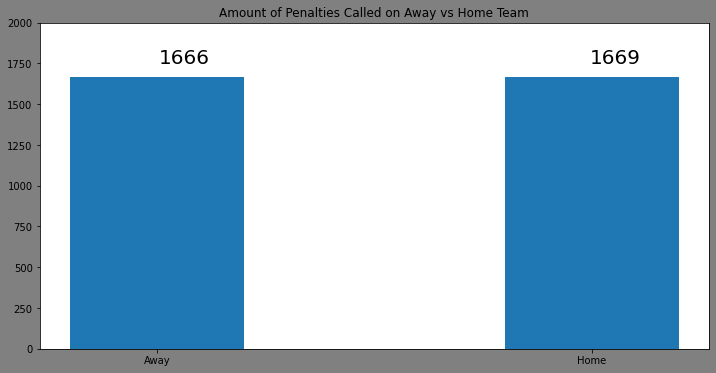

In [112]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='gray')

xs = ['Away', 'Home']
vs = np.count_nonzero(penalty_frame['Called On'].values=='V')
hs = np.count_nonzero(penalty_frame['Called On'].values=='H')
ys = [vs, hs]
ax.bar(xs, ys, width=.4)

ax.set_title('Amount of Penalties Called on Away vs Home Team')
ax.set_ylim(0, 2000)

ax.text(.005, vs* 1.05, vs, size=20)
ax.text(.995, hs* 1.05, hs, size=20)

None # avoid printing a matplotlib object

As we can see here, the trend is almost completely even. Nothing to see here. But of course the league as a whole would even out. Lets take a look at how this trend looks for each ref.

Text(0.5, 1.0, 'Amount of Penalties Called on Away vs Home Team (by Ref)')

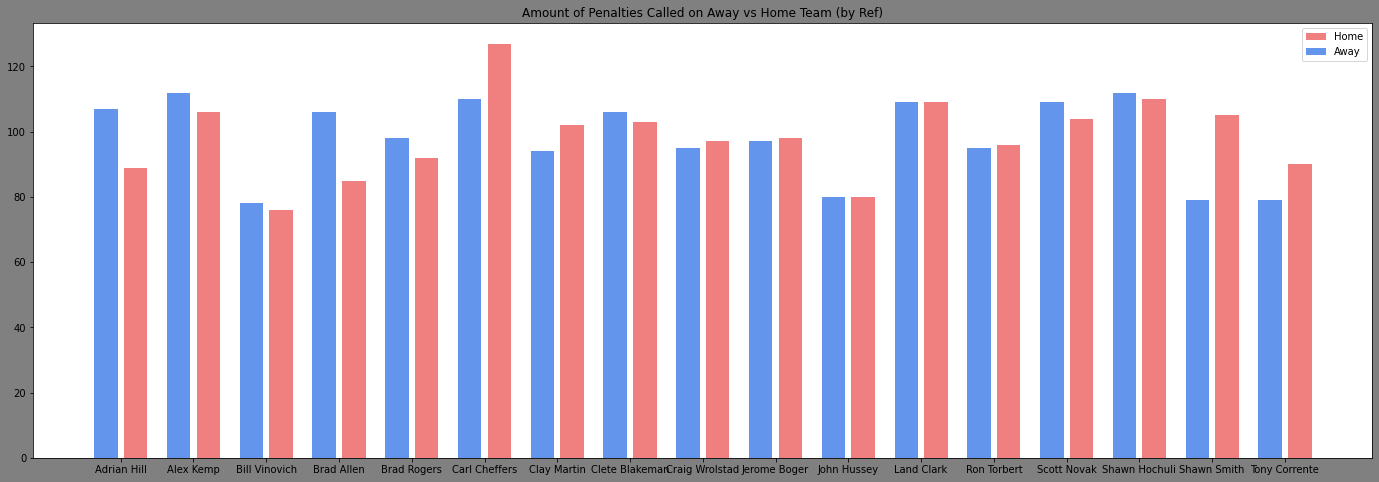

In [156]:
fig, ax = plt.subplots(figsize=(24,8), facecolor='gray')

by_ref = penalty_frame.groupby('Ref')

aways_y = [np.count_nonzero(penalties['Called On'].values=='V') for _, penalties in by_ref]
homes_y = [np.count_nonzero(penalties['Called On'].values=='H') for _, penalties in by_ref]
aways_x = [x-.012  for x in xs]
homes_x = [x+.012 for x in xs]
ax.bar(homes_x, homes_y, width=.019, label='Home', color='lightcoral')
ax.bar(aways_x, aways_y, width=.019, label='Away', color='cornflowerblue')
ax.set_xticks(xs)
ax.set_xticklabels(by_ref.indices.keys())
ax.legend()

ax.set_title('Amount of Penalties Called on Away vs Home Team (by Ref)')
